In [55]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
from methods.fit_linear_regression_model import fit_linear_regression_model
import sklearn
%matplotlib inline

In [56]:
file = uproot.open(
    "tracking_losses_ntuple_B_default_radlength_endVelo.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) &
                   (allcolumns.fromB)]  # B: 9056
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) &
                  (allcolumns.fromB)]  # B: 1466

electrons = allcolumns[(allcolumns.isElectron) & (allcolumns.fromB)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

40402 10099
50501


In [57]:
rad_length_found = ak.to_numpy(found["rad_length_frac"])
eta_found = ak.to_numpy(found["eta"])
rad_length_lost = ak.to_numpy(lost["rad_length_frac"])
eta_lost = ak.to_numpy(lost["eta"])

stretch_factor = ak.num(eta_lost, axis=0) / ak.num(eta_found, axis=0)
print("stretch factor: ", stretch_factor)

stretch factor:  0.24996287312509283


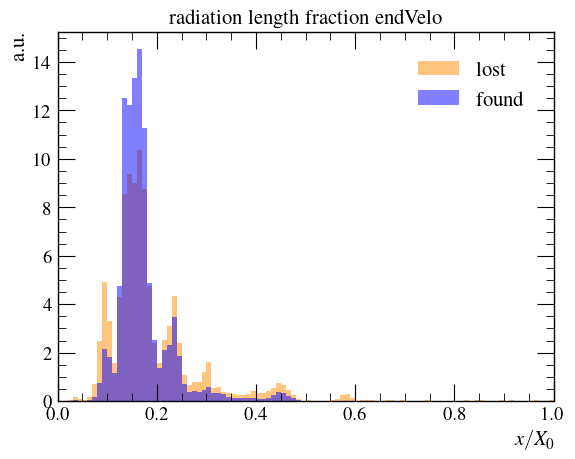

In [58]:
plt.hist(
    rad_length_lost,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="lost",
    range=[0, 1],
)
plt.hist(
    rad_length_found,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="found",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction endVelo")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")

plt.legend()
plt.show()

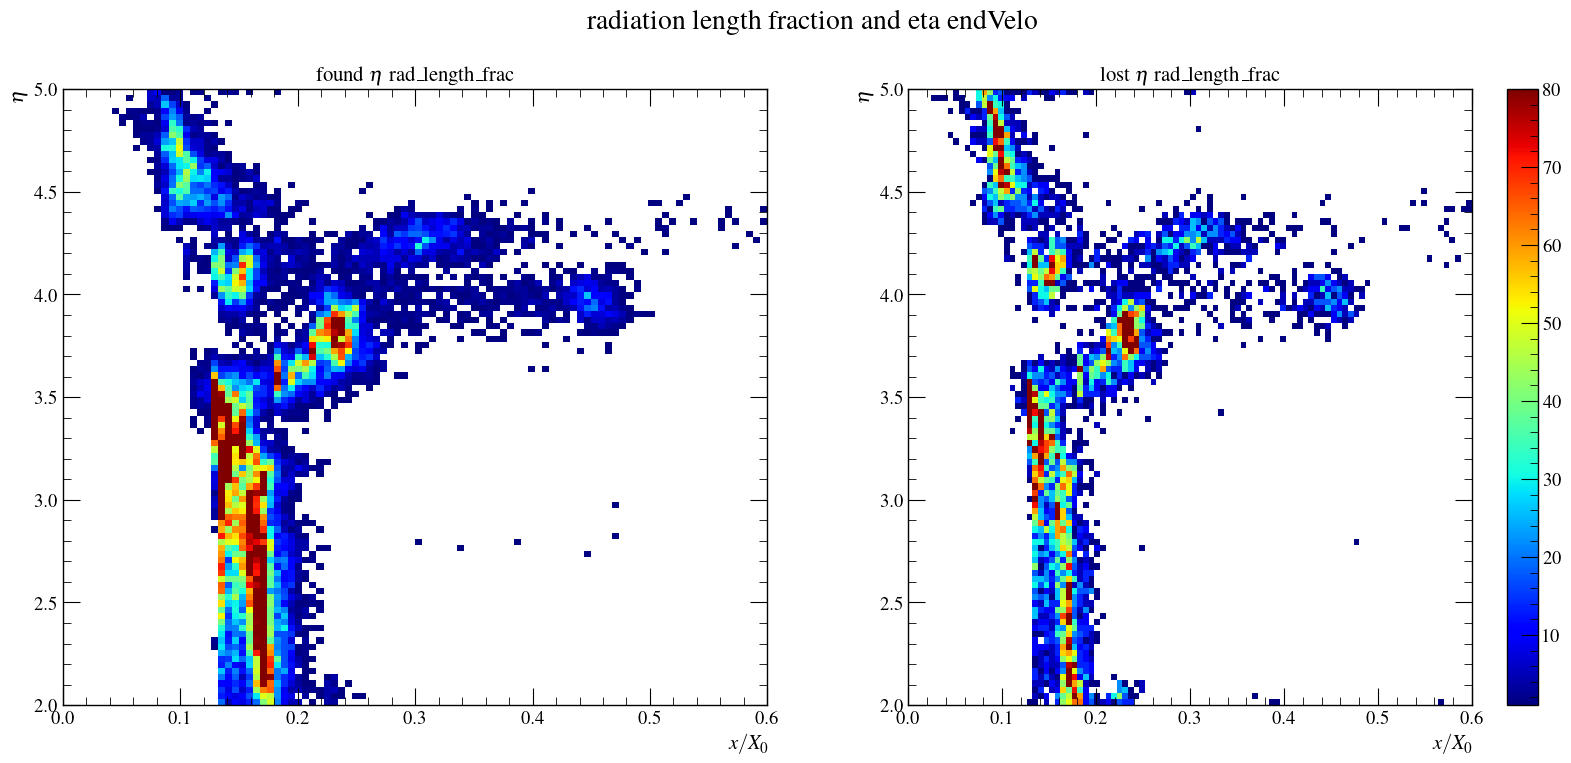

In [59]:
nbins = 100
vmax = 80

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

a0 = ax0.hist2d(
    rad_length_found,
    eta_found,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[0, 0.6], [2, 5]],
)
ax0.set_xlabel(f"$x/X_0$")
ax0.set_ylabel(f"$\eta$")
ax0.set_title(f"found $\eta$ rad_length_frac")

a1 = ax1.hist2d(
    rad_length_lost,
    eta_lost,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[0, 0.6], [2, 5]],
)
ax1.set_xlabel(f"$x/X_0$")
ax1.set_ylabel(f"$\eta$")
ax1.set_title(f"lost $\eta$ rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.suptitle("radiation length fraction and eta endVelo")
plt.colorbar(a0[3], ax=ax1)

plt.show()

In [60]:
rad_length_frac = found["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = found["ideal_state_770_tx"]
    slopey = found["ideal_state_770_ty"]
    x = found["ideal_state_770_x"]
    y = found["ideal_state_770_y"]
    qop = found["ideal_state_770_qop"]
elif state == 2:
    slopex = found["ideal_state_9410_tx"]
    slopey = found["ideal_state_9410_ty"]
    x = found["ideal_state_9410_x"]
    y = found["ideal_state_9410_y"]
    qop = found["ideal_state_9410_qop"]

data = ak.zip({
    "rad_length_frac": rad_length_frac,
    "x": x,
    "y": y,
    "tx": slopex,
    "ty": slopey,
    "qop": qop,
})

In [61]:
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    5,
    include_bias=True,
)

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.19432666451166924, 'x': -0.00010136532791187516, 'y': -0.00022209404990607013, 'tx': 0.058480207541052064, 'ty': 0.18599542917589618, 'qop': -17.657405901936546, 'x^2': 1.2271024867047469e-05, 'x y': 5.376824972059055e-08, 'x tx': -0.025941371835257743, 'x ty': 0.014328015524776564, 'x qop': -0.38410998543244235, 'y^2': -1.8261507968709735e-05, 'y tx': -0.014951077113227147, 'y ty': 0.02154311538810164, 'y qop': -0.008987663050567057, 'tx^2': 9.180854607357592, 'tx ty': 0.1873064867954838, 'tx qop': -0.47120712928737807, 'ty^2': -6.787398610853974, 'ty qop': -0.05031041352613623, 'qop^2': 0.24778641944197533, 'x^3': -5.992321693190818e-09, 'x^2 y': -2.649404482539432e-07, 'x^2 tx': 5.42176741002125e-06, 'x^2 ty': 0.0020253771536145383, 'x^2 qop': 0.003955288970107154, 'x y^2': 2.8906882704270233e-09, 'x y tx': -0.0016493773782229844, 'x y ty': 0.0005067592007986898, 'x y qop': -0.0031813438496783404, 'x tx^2': 0.0022653

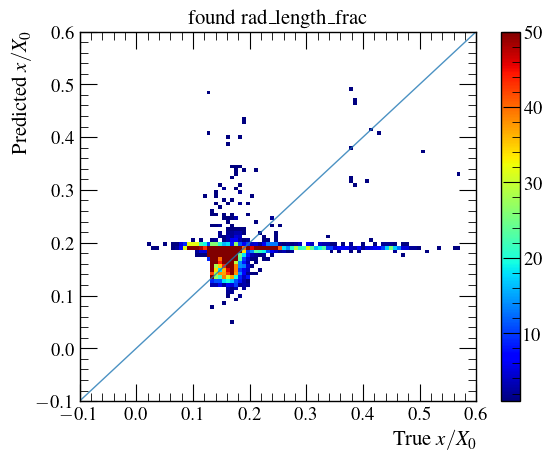

In [62]:
nbins = 100
vmax = 50

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[-0.1, 0.6], [-0.1, 0.6]],
)
plt.plot([-0.1, 0.6], [-0.1, 0.6], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"found rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3])
plt.show()